In [6]:
import sys
# from transformers import PatchTSTForPretraining

# override PatchTSTForPretrainingOutput data class
from transformers.models.patchtst.modeling_patchtst import PatchTSTPreTrainedModel, PatchTSTModel, PatchTSTMaskPretrainHead
# from transformers.models.patchtst.modeling_patchtst import PatchTSTForPretrainingOutput
from transformers.models.patchtst.configuration_patchtst import PatchTSTConfig
from transformers.utils import ModelOutput
import torch
import torch.nn as nn
from typing import Optional, Tuple, Union
from dataclasses import dataclass

@dataclass
class PatchTSTForPretrainingOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    prediction_output: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    mask: torch.FloatTensor = None

# @add_start_docstrings(
#     "The PatchTST for pretrain model.",
#     PATCHTST_START_DOCSTRING,
# )
class PatchTSTForPretraining(PatchTSTPreTrainedModel):
    def __init__(self, config: PatchTSTConfig):
        super().__init__(config)

        config.do_mask_input = True
        self.model = PatchTSTModel(config=config)
        self.head = PatchTSTMaskPretrainHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        past_values: torch.Tensor,
        past_observed_mask: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, PatchTSTForPretrainingOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # past_values: [bs x num_channels x num_patches x d_model] or
        # [bs x num_channels x (num_patches+1) x d_model] if use cls_token
        model_output = self.model(
            past_values=past_values,
            past_observed_mask=past_observed_mask,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=True,
        )
        # last_hidden_state: [bs x num_channels x num_patches x patch_length] or
        # [bs x num_channels x (num_patches+1) x patch_length] if use cls_token
        x_hat = self.head(model_output.last_hidden_state)

        # calculate masked_loss
        loss = nn.MSELoss(reduction="none")
        loss_val = loss(x_hat, model_output.patch_input)
        masked_loss = (loss_val.mean(dim=-1) * model_output.mask).sum() / (model_output.mask.sum() + 1e-10)

        encoder_states = model_output.hidden_states
        if not return_dict:
            outputs = (x_hat,) + model_output[1:-4]
            outputs = (masked_loss,) + outputs if masked_loss is not None else outputs
            return outputs
        return PatchTSTForPretrainingOutput(
            loss=masked_loss, prediction_output=x_hat, hidden_states=encoder_states, attentions=model_output.attentions
            , mask=model_output.mask
        )

In [7]:


sys.path.append('../PatchTST_self_supervised')
from src.data.pred_dataset import TUH_Dataset_Test

context_length = 1000
patch_length = 100

tuh_train_data = TUH_Dataset_Test(
    # root_path='/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test',#'/mnt/ssd_4tb_0/data/tuh_preprocessed_npy',
    root_path='/home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped',
    data_path='',
    csv_path='/home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped/tuhab_records_cropped.csv',
    features='M',
    scale=False,
    size=[context_length, 0, patch_length],
    use_time_features=False
)

tuh_eval_data = TUH_Dataset_Test(
    # root_path='/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test',#'/mnt/ssd_4tb_0/data/tuh_preprocessed_npy',
    root_path='/home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped',
    data_path='',
    csv_path='/home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped/tuhab_records_cropped.csv',
    features='M',
    scale=False,
    size=[context_length, 0, patch_length],
    use_time_features=False,
    split='val'
)


Found 10 patients with 10 files
Loaded existing patient splits from /home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped/tuh_patient_splits.pkl
Split: train, Patients: 7, Files: 7
Total Sequences: 469007
Found 10 patients with 10 files
Loaded existing patient splits from /home/gayal/ssl-analyses-repos/PatchTST/tuhab_records/tuhab_records_cropped/tuh_patient_splits.pkl
Split: val, Patients: 1, Files: 1
Total Sequences: 72601


seq_x.shape torch.Size([1, 1000, 19])
odict_keys(['loss', 'prediction_output', 'mask'])
reconstruction.shape torch.Size([1, 1000, 19])
mask.shape torch.Size([1, 19, 10])
mask.shape: (1, 19, 10)
[False  True False False False  True False False  True  True]
new_mask.shape: (1, 1000)


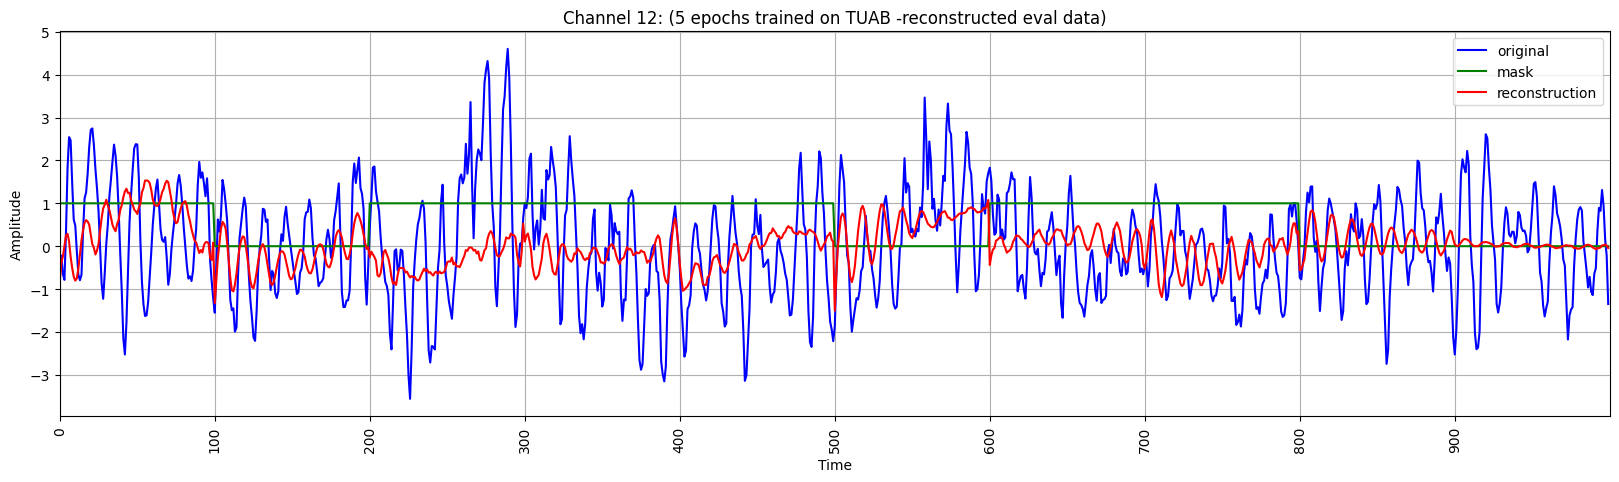

In [42]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


batch_size = 1
# dataloader = DataLoader(tuh_train_data, batch_size=batch_size, shuffle=False)
dataloader = DataLoader(tuh_eval_data, batch_size=batch_size, shuffle=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)

mask_ratio = 0.4
patch_length = 100
patch_stride = 100

# num patches 
num_patches = context_length//patch_length


def reconstruction_vis(model, dataloader, mask_ratio, sample):
    model.to(device)
    model.eval()

    # get sample th batch from dataloader without looping
    for i, batch in enumerate(dataloader):
        if i == sample:
            seq_x = batch['past_values'].to(device)   # [batch_size, context_length, num_channels]
            print('seq_x.shape', seq_x.shape)
            with torch.no_grad():
                outputs = model(seq_x)
                print(outputs.keys())
                reconstruction = outputs['prediction_output'] # [batch_size, num_channels, num_patches, patch_length]
                reconstruction = reconstruction.permute(0, 2, 3, 1) # [batch_size, num_patches, patch_length, num_channels]
                # reshape to [batch_size, num_patches * patch_length, num_channels]
                reconstruction = reconstruction.reshape(reconstruction.shape[0], -1, reconstruction.shape[3])
                print('reconstruction.shape', reconstruction.shape)
                mask = outputs['mask'] # [batch_size, nunm_channels, num_patches]
                # mask.permute(0, 2, 1) # [batch_size, num_patches, num_channels]
                print('mask.shape', mask.shape)

                return reconstruction.cpu().numpy(), seq_x.cpu().numpy(), mask.cpu().numpy()
        
    return None, None

import os
checkpoint_path_dir = '/home/gayal/ssl-analyses-repos/PatchTST/PatchTST_self_supervised/saved_models/tuhab_10000/outputs'
checkpoint = 'checkpoint-10000'

check_path = os.path.join(checkpoint_path_dir, checkpoint)
model = PatchTSTForPretraining.from_pretrained(check_path)

reconstruction, seq_x, mask = reconstruction_vis(model, dataloader, mask_ratio, 2)
# if reconstruction == None and seq_x==None:
#     import sys
#     sys.exit(0)

assert reconstruction.shape == seq_x.shape, f"Reconstruction shape {reconstruction.shape} does not match input shape {seq_x.shape}"

# select one channel for visualization
channel = 12
reconstruction = reconstruction[:, :, channel] # [batch_size, num_patches, patch_length]
seq_x = seq_x[:, :, channel] # [batch_size, context_length]
print(f"mask.shape: {mask.shape}")
mask = mask[:, channel, :] # [batch_size, num_patches]
print(mask[0])
# for each value in mask create patch_length number of 1s if True 0s if False
new_mask = []
for i in range(mask.shape[1]):
    if mask[0, i] == 1:
        new_mask.append([0] * patch_length)
    else:
        new_mask.append([1] * patch_length)
mask = np.array(new_mask).reshape(1, -1)
print(f"new_mask.shape: {mask.shape}")

import numpy as np
import matplotlib.pyplot as plt

def plot_reconstruction(reconstruction, seq_x, mask, channel):
    # plot the reconstruction and the original signal
    plt.figure(figsize=(20, 5))
    plt.plot(seq_x[0, :], label='original', color='blue')
    plt.plot(mask[0, :], label='mask', color='green')
    plt.plot(reconstruction[0, :], label='reconstruction', color='red')
    plt.xticks(np.arange(0, seq_x.shape[1], patch_length), rotation=90)
    plt.xlim(0, seq_x.shape[1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    # plt.title(f'Channel {channel}')
    plt.title(f'Channel {channel}: (5 epochs trained on TUAB -reconstructed eval data)')
    plt.legend()
    plt.show()
# plot the reconstruction and the original signal
reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
plot_reconstruction(reconstruction, seq_x, mask, channel)

# # save the reconstruction and the original signal
# reconstruction = reconstruction.cpu().numpy()
# seq_x = seq_x.cpu().numpy()
# np.save('reconstruction.npy', reconstruction)
# np.save('seq_x.npy', seq_x)
# PatchTSTForPretraining -> PatchTSTModel -> PatchTSTMasking -> random_masking

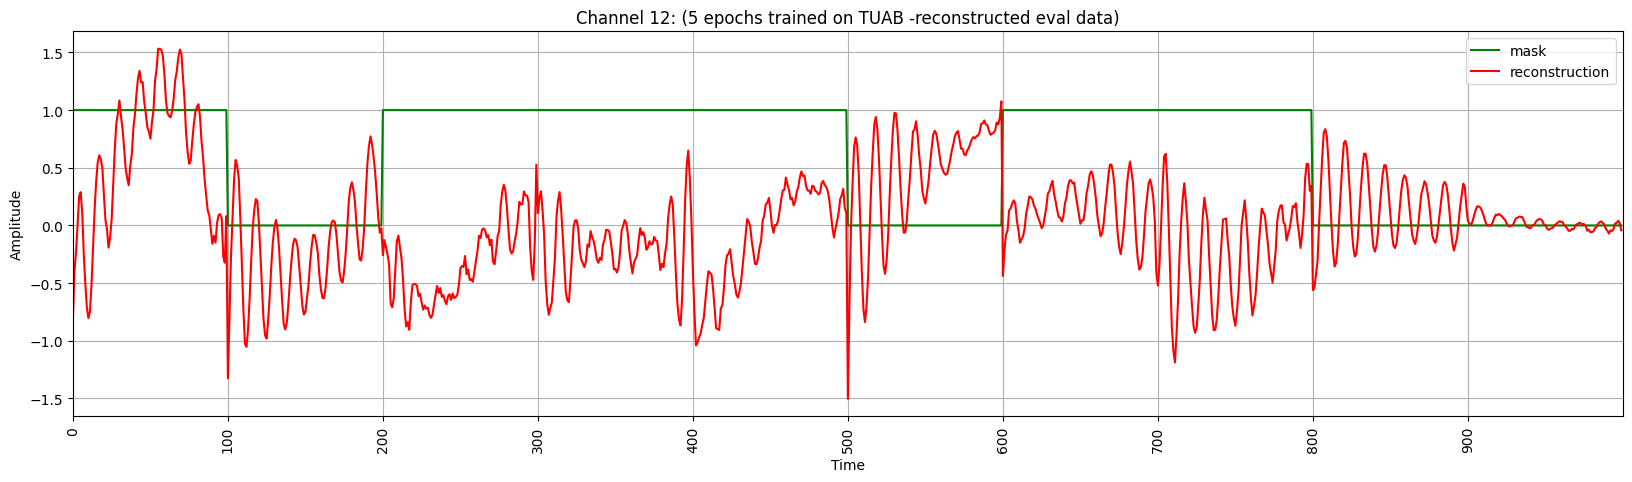

In [43]:
def plot_reconstruction(reconstruction, seq_x, mask, channel):
    # plot the reconstruction and the original signal
    plt.figure(figsize=(20, 5))
    # plt.plot(seq_x[0, :], label='original', color='blue')
    plt.plot(mask[0, :], label='mask', color='green')
    plt.plot(reconstruction[0, :], label='reconstruction', color='red')
    plt.xticks(np.arange(0, seq_x.shape[1], patch_length), rotation=90)
    plt.xlim(0, seq_x.shape[1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.title(f'Channel {channel}: (5 epochs trained on TUAB -reconstructed eval data)')
    plt.legend()
    plt.show()
# plot the reconstruction and the original signal
reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
plot_reconstruction(reconstruction, seq_x, mask, channel)

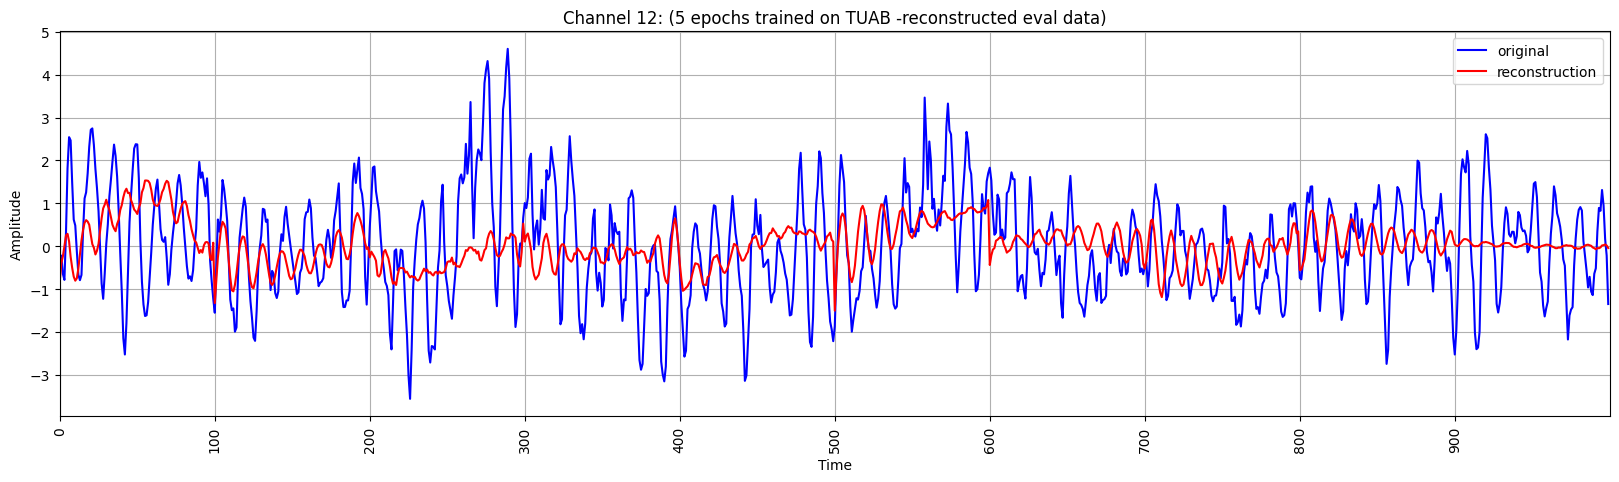

In [44]:
def plot_reconstruction(reconstruction, seq_x, channel):
    # plot the reconstruction and the original signal
    plt.figure(figsize=(20, 5))
    plt.plot(seq_x[0, :], label='original', color='blue')
    plt.plot(reconstruction[0, :], label='reconstruction', color='red')
    # plt.title(f'Channel {channel}')
    plt.title(f'Channel {channel}: (5 epochs trained on TUAB -reconstructed eval data)')
    # grid at every patch_length
    plt.xticks(np.arange(0, seq_x.shape[1], patch_length), rotation=90)
    plt.xlim(0, seq_x.shape[1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()
# plot the reconstruction and the original signal
reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
plot_reconstruction(reconstruction, seq_x, channel)

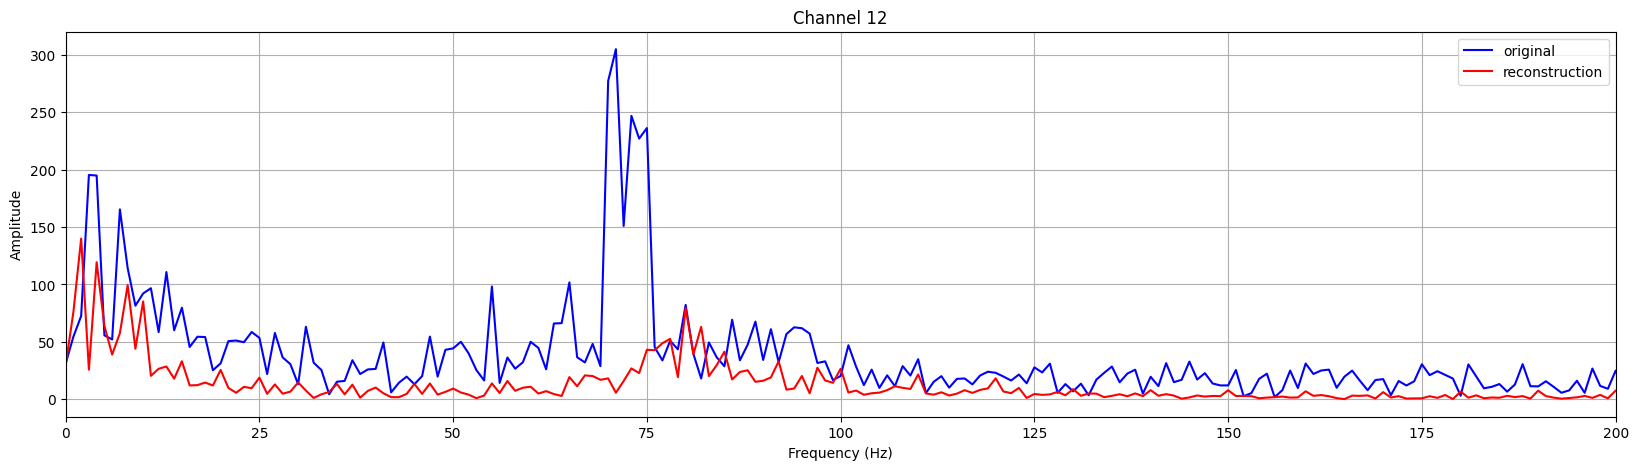

In [45]:
# plot the power spectrum of the reconstruction and the original signal between 0 and 50 Hz
def plot_power_spectrum(reconstruction, seq_x, channel):
    # plot the power spectrum of the reconstruction and the original signal
    plt.figure(figsize=(20, 5))
    plt.plot(np.abs(np.fft.fft(seq_x[0, :]))[:seq_x.shape[1]//2], label='original', color='blue')
    plt.plot(np.abs(np.fft.fft(reconstruction[0, :]))[:reconstruction.shape[1]//2], label='reconstruction', color='red')
    plt.title(f'Channel {channel}')
    plt.xlim(0, 200)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()

# plot the power spectrum of the reconstruction and the original signal
reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
plot_power_spectrum(reconstruction, seq_x, channel)

In [36]:
# data_procd_path = '/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test'
# pkl_filename = 'tuh_patient_splits.pkl'

# import pandas as pd
# import pickle
# import os
# import numpy as np

# def load_patient_splits(data_procd_path, pkl_filename):
#     # Load the patient splits from the pickle file
#     with open(os.path.join(data_procd_path, pkl_filename), 'rb') as f:
#         patient_splits = pickle.load(f)

#     return patient_splits

# patient_splits = load_patient_splits(data_procd_path, pkl_filename)
# patient_splits['val']

In [19]:
# # find the matching patient_splits['val'][0] in the directory
# import os

# recording_name = ''

# for root, dirs, files in os.walk(data_procd_path):
#     for file in files:
#         if patient_splits['val'][0] in file:
#             recording_name = file
#             print(os.path.join(root, file))
#             break

# recording_name = recording_name.split('_preprocessed.npy')[0]
# # find that from the original recording
# raw_data_path = '/mnt/hdd_16tb_0/tuh/edf'

# edf_file_path = ''
# # walk and find the file
# for root, dirs, files in os.walk(raw_data_path):
#     for file in files:
#         if recording_name in file:
#             edf_file_path = os.path.join(root, file)
#             print(edf_file_path)
#             break


In [20]:
# # %matplotlib notebook

# import mne
# raw = mne.io.read_raw_edf(edf_file_path, preload=True)
# raw.load_data()
# raw.pick_types(eeg=True)
# raw.plot()

Original Input Shape: torch.Size([1, 1000, 19])
Masked Input Shape: torch.Size([1, 1000, 19])
Mask Shape: torch.Size([1, 19, 1000])
Reconstruction Shape: torch.Size([1, 1000, 19])


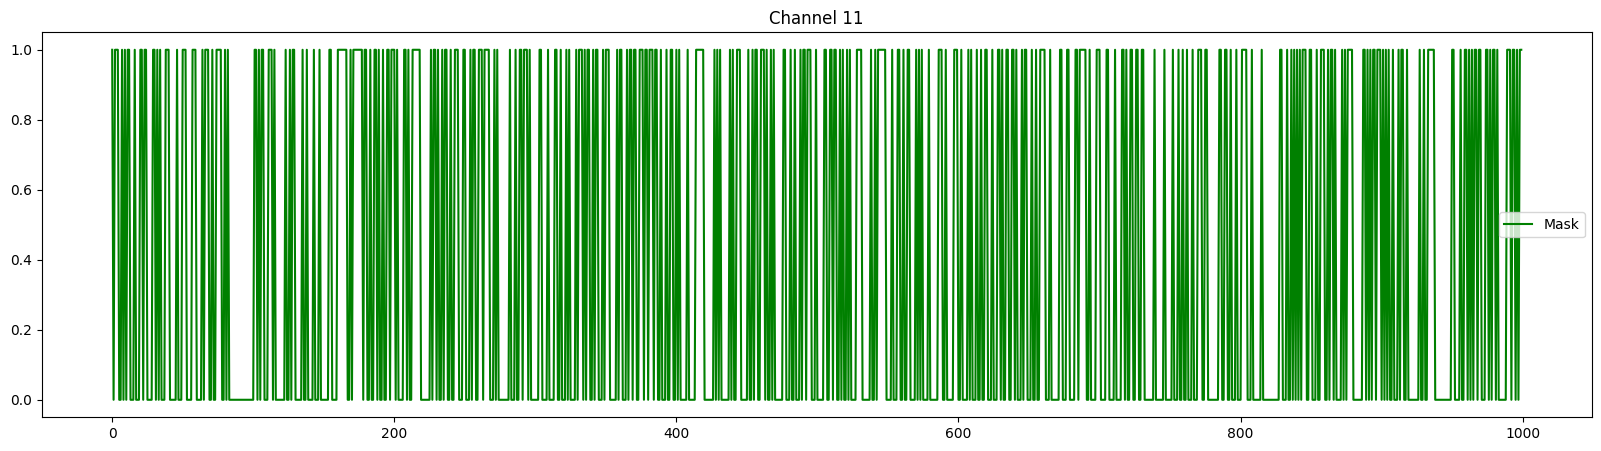

In [31]:
import torch
from transformers import PatchTSTForPretraining, PatchTSTModel
from torch.utils.data import DataLoader

# Load the trained model
checkpoint_path = "/home/gayal/ssl-analyses-repos/PatchTST/PatchTST_self_supervised/saved_models/tuhab_10000/outputs/checkpoint-10000"
model = PatchTSTForPretraining.from_pretrained(checkpoint_path)
model.eval()

# Prepare the dataloader (as in the notebook)
batch_size = 1
context_length = 1000
patch_length = 100
mask_ratio = 0.4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assuming `tuh_eval_data` is already defined
dataloader = DataLoader(tuh_eval_data, batch_size=batch_size, shuffle=False)

# Function to mask the input signal
def apply_random_masking(inputs, mask_ratio, channel_consistent_masking=True):
    from transformers.models.patchtst.modeling_patchtst import random_masking
    inputs = inputs.permute(0, 2, 1).unsqueeze(-1)  # Reshape to [batch_size, num_channels, sequence_length, 1]
    masked_inputs, mask = random_masking(inputs, mask_ratio, channel_consistent_masking=False)
    return masked_inputs.squeeze(-1).permute(0, 2, 1), mask  # Reshape back to [batch_size, sequence_length, num_channels]

# Perform inference
for i, batch in enumerate(dataloader):
    if i == 0:  # Process only the first batch for demonstration
        seq_x = batch["past_values"].to(device)  # [batch_size, context_length, num_channels]
        print("Original Input Shape:", seq_x.shape)

        # Apply masking
        masked_seq_x, mask = apply_random_masking(seq_x, mask_ratio)
        print("Masked Input Shape:", masked_seq_x.shape)
        print("Mask Shape:", mask.shape)
        mask = mask.permute(0, 2, 1)  # Reshape mask to [batch_size, num_channels, sequence_length]

        # Predict the masked portions
        with torch.no_grad():
            outputs = model(masked_seq_x)
            reconstruction = outputs["prediction_output"]  # [batch_size, num_channels, num_patches, patch_length]
            reconstruction = reconstruction.permute(0, 2, 3, 1)
            reconstruction = reconstruction.reshape(reconstruction.shape[0], -1, reconstruction.shape[3])
            print("Reconstruction Shape:", reconstruction.shape)


        # Visualize the original, masked, and reconstructed signals
        import matplotlib.pyplot as plt
        channel = 11  # Visualize a single channel
        plt.figure(figsize=(20, 5))
        # plt.plot(seq_x[0, :, channel].cpu(), label="Original Signal", color="blue")
        plt.plot(mask[0, :, channel].cpu(), label="Mask", color="green")
        # plt.plot(masked_seq_x[0, :, channel].cpu(), label="Masked Signal", color="orange")
        # plt.plot(reconstruction[0, :, channel].cpu(), label="Reconstructed Signal", color="red")
        plt.legend()
        plt.title(f"Channel {channel}")
        plt.show()

        break

Squeezed Mask Shape: torch.Size([19, 1000])


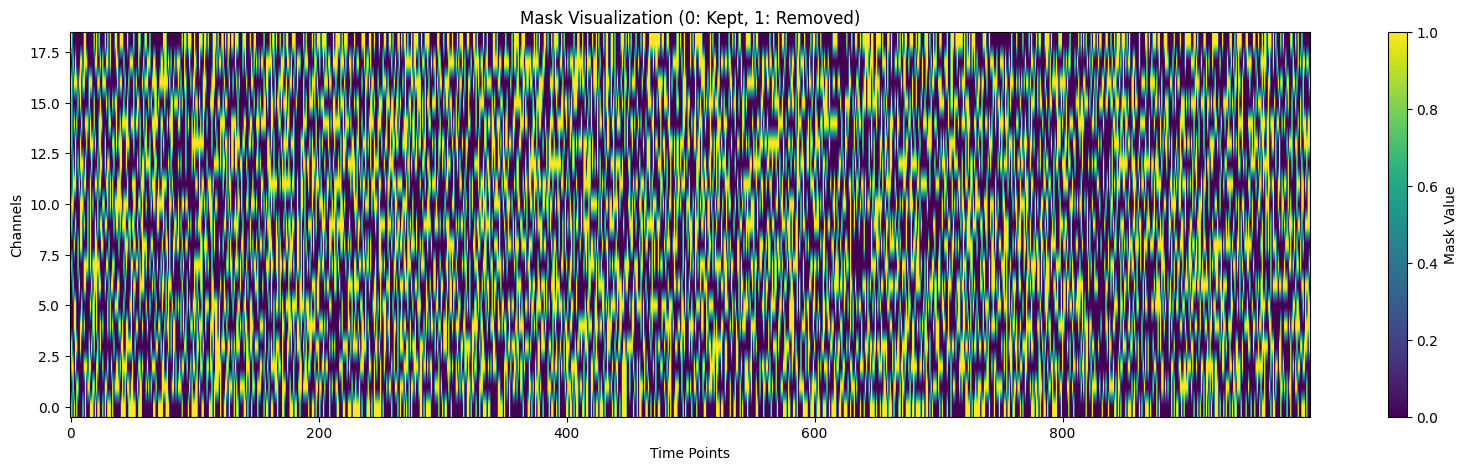

In [38]:
sqzd_mask = mask.squeeze(0).T[:, :1000]
print("Squeezed Mask Shape:", sqzd_mask.shape)

# Visualize the mask 19 channels x 1000 time points
plt.figure(figsize=(20, 5))
plt.imshow(sqzd_mask.cpu(), aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Mask Value')
plt.title('Mask Visualization (0: Kept, 1: Removed)')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.show()


In [ ]:
def random_masking(xb, mask_ratio):
    # xb: [bs x num_patch x n_vars x patch_len]
    bs, L, nvars, D = xb.shape
    x = xb.clone()
    
    len_keep = int(L * (1 - mask_ratio))
        
    noise = torch.rand(bs, L, nvars,device=xb.device)  # noise in [0, 1], bs x L x nvars
        
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)                                     # ids_restore: [bs x L x nvars]

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep, :]                                              # ids_keep: [bs x len_keep x nvars]         
    x_kept = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, 1, D))     # x_kept: [bs x len_keep x nvars  x patch_len]
   
    # removed x
    x_removed = torch.zeros(bs, L-len_keep, nvars, D, device=xb.device)                 # x_removed: [bs x (L-len_keep) x nvars x patch_len]
    x_ = torch.cat([x_kept, x_removed], dim=1)                                          # x_: [bs x L x nvars x patch_len]

    # combine the kept part and the removed one
    x_masked = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1,1,1,D)) # x_masked: [bs x num_patch x nvars x patch_len]

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([bs, L, nvars], device=x.device)                                  # mask: [bs x num_patch x nvars]
    mask[:, :len_keep, :] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)                                  # [bs x num_patch x nvars]
    return x_masked, x_kept, mask, ids_restore

Original Input Shape: torch.Size([1, 1000, 19])
Masked Input Shape: torch.Size([1, 1000, 19])
Mask Shape: torch.Size([1, 19, 1000])
Reconstruction Shape: torch.Size([1, 1000, 19])


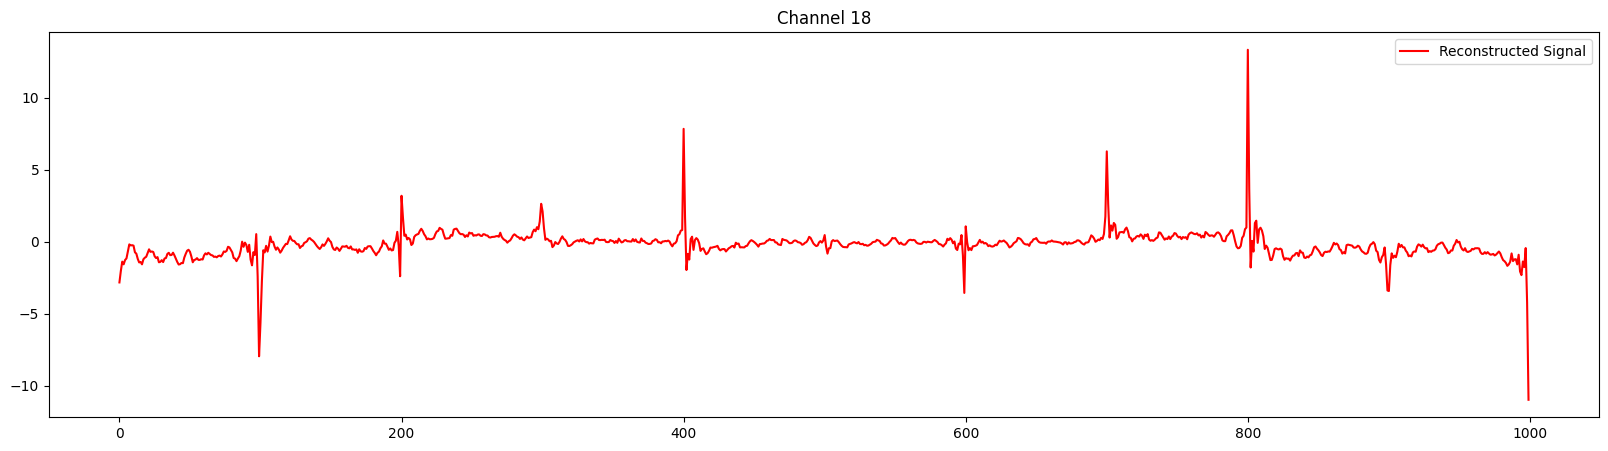

In [24]:
import torch
from transformers import PatchTSTForPretraining
from torch.utils.data import DataLoader

# Load the trained model
checkpoint_path = "/home/gayal/ssl-analyses-repos/PatchTST/PatchTST_self_supervised/saved_models/tuhab_10000/outputs/checkpoint-10000"
model = PatchTSTForPretraining.from_pretrained(checkpoint_path)
model.eval()

# Prepare the dataloader (as in the notebook)
batch_size = 1
context_length = 1000
patch_length = 100
mask_ratio = 0.4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assuming `tuh_eval_data` is already defined
dataloader = DataLoader(tuh_eval_data, batch_size=batch_size, shuffle=False)

# Function to mask the input signal
def apply_random_masking(inputs, mask_ratio):
    inputs = inputs.permute(0, 2, 1).unsqueeze(-1)  # Reshape to [batch_size, num_channels, sequence_length, 1]
    masked_inputs, kept_input, mask, ids_restore = random_masking(inputs, mask_ratio)
    return masked_inputs.squeeze(-1).permute(0, 2, 1), mask  # Reshape back to [batch_size, sequence_length, num_channels]

# Perform inference
for i, batch in enumerate(dataloader):
    if i == 0:  # Process only the first batch for demonstration
        seq_x = batch["past_values"].to(device)  # [batch_size, context_length, num_channels]
        print("Original Input Shape:", seq_x.shape)

        # Apply masking
        masked_seq_x, mask = apply_random_masking(seq_x, mask_ratio)
        print("Masked Input Shape:", masked_seq_x.shape)
        print("Mask Shape:", mask.shape)
        # mask = mask.permute(0, 2, 1)  # Reshape mask to [batch_size, num_channels, sequence_length]

        # Predict the masked portions
        with torch.no_grad():
            outputs = model(masked_seq_x)
            reconstruction = outputs["prediction_output"]  # [batch_size, num_channels, num_patches, patch_length]
            reconstruction = reconstruction.permute(0, 2, 3, 1)
            reconstruction = reconstruction.reshape(reconstruction.shape[0], -1, reconstruction.shape[3])
            print("Reconstruction Shape:", reconstruction.shape)


        # Visualize the original, masked, and reconstructed signals
        import matplotlib.pyplot as plt
        channel = 18  # Visualize a single channel
        plt.figure(figsize=(20, 5))
        # plt.plot(seq_x[0, :, channel].cpu(), label="Original Signal", color="blue")
        # plt.plot(mask[0, channel, :].cpu(), label="Masked Signal", color="green")
        # plt.plot(masked_seq_x[0, :, channel].cpu(), label="Masked Signal", color="orange")
        plt.plot(reconstruction[0, :, channel].cpu(), label="Reconstructed Signal", color="red")
        plt.legend()
        plt.title(f"Channel {channel}")
        plt.show()

        break

Squeezed Mask Shape: torch.Size([19, 1000])


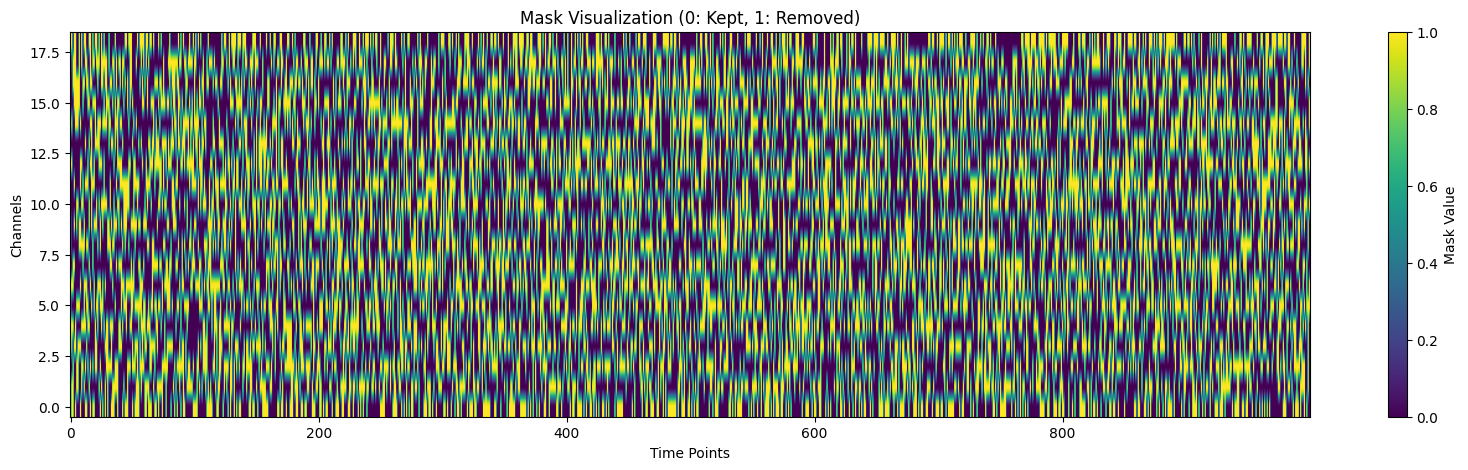

In [ ]:
sqzd_mask = mask.squeeze(0)
print("Squeezed Mask Shape:", sqzd_mask.shape)

# Visualize the mask 19 channels x 1000 time points
plt.figure(figsize=(20, 5))
plt.imshow(sqzd_mask.cpu(), aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Mask Value')
plt.title('Mask Visualization (0: Kept, 1: Removed)')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.show()


In [56]:
l = [sum(sqzd_mask[i, :]) for i in range(sqzd_mask.shape[0])]
print(sum(l)/19000)


tensor(0.4211, device='cuda:0')


In [62]:
def random_masking(
    inputs: torch.Tensor,
    mask_ratio: float,
    unmasked_channel_indices: list = None,
    channel_consistent_masking: bool = False,
    mask_value: int = 0,
):
    """random_masking: Mask the input considering the control variables.

    Args:
        inputs (`torch.Tensor` of shape `(batch_size, num_channels, sequence_length, num_features)`):
            The input tensor to mask.
        mask_ratio (`float`):
            Masking ratio applied to mask the input data during random pretraining. It is the number between 0 and 1.
        unmasked_channel_indices (list, *optional*):
            Indices of channels that will not be masked.
        channel_consistent_masking (bool, *optional*, defaults to `False`):
            When true, masking will be same across all channels of a timeseries. Otherwise, masking positions will vary
            across channels.
        mask_value (int, *optional*, defaults to 0):
            Define the value of masked patches for pretraining.

    Returns:
        `tuple(torch.Tensor)`: inputs_mask, masked input, same shape as input Tensor and mask tensor of shape [bs x c x
        n]
    """
    if mask_ratio < 0 or mask_ratio >= 1:
        raise ValueError(f"Mask ratio {mask_ratio} has to be between 0 and 1.")

    batch_size, num_channels, sequence_length, num_features = inputs.shape
    device = inputs.device

    len_keep = int(sequence_length * (1 - mask_ratio))

    if channel_consistent_masking:
        noise = torch.rand(batch_size, 1, sequence_length, device=device)  # noise in [0, 1], bs x 1 x  L
        noise = noise.repeat(1, num_channels, 1)  # bs x num_channels x time
    else:
        # noise in [0, 1], bs x num_channels x L
        noise = torch.rand(batch_size, num_channels, sequence_length, device=device)

    # mask: [bs x num_channels x num_patch]
    mask = torch.ones(batch_size, num_channels, sequence_length, device=device)
    mask[:, :, :len_keep] = 0

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=-1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=-1)  # ids_restore: [bs x num_channels x L]

    mask = torch.gather(mask, dim=-1, index=ids_restore)
    mask = mask.unsqueeze(-1).repeat(1, 1, 1, num_features)  # mask: [bs x num_channels x num_patches x patch_length]
    if unmasked_channel_indices is not None:
        mask[:, unmasked_channel_indices, :, :] = 0

    inputs_mask = inputs.masked_fill(mask.bool(), mask_value)
    return inputs_mask, mask[..., 0]

# Example usage
inputs = seq_x  # batch_size=2, num_channels=19, sequence_length=1000, num_features=1
mask_ratio = 0.4
masked_inputs, mask = random_masking(inputs, mask_ratio, channel_consistent_masking=True)
print("Masked Inputs Shape:", masked_inputs.shape)

# Visualize the masked inputs
import matplotlib.pyplot as plt

channel = 0  # Visualize a specific channel
plt.figure(figsize=(20, 5))
plt.plot(inputs[0, channel, :, 0].cpu(), label="Original Signal", color="blue")
plt.plot(masked_inputs[0, channel, :, 0].cpu(), label="Masked Signal", color="orange")
plt.title(f"Channel {channel}")
plt.legend()
plt.show()

ValueError: not enough values to unpack (expected 4, got 2)

In [63]:
seq_x.shape

(1, 1000)

## TUHAB VAL preprocessed signal